In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam


# загрузка данных
df = pd.read_excel('общая_СКР.xlsx', sheet_name='СКР')
df_1 = pd.read_excel('общая_ОПЖ.xlsx',sheet_name='ОПЖ')

In [287]:
# форматирование регионов
def region_fix(df, region_column='Регион'):
    
    # основные замены
    fixes = {
        r'г\.?\s*москва': 'Москва',
        r'г\.?\s*санкт-петербург': 'Санкт-Петербург', 
        r'г\.?\s*севастополь': 'Севастополь',
        r'республика татарстан\s*\(татарстан\)': 'Республика Татарстан',
        r'чувашская республика\s*\(чувашия\)': 'Чувашская Республика',
        r'республика северная осетия\s*[-]?\s*алания': 'Республика Северная Осетия - Алания',
        r'ханты-мансийский\s*(авт\.?|автономный)\s*округ\s*[-]?\s*югра': 'Ханты-Мансийский автономный округ - Югра',
        r'ямало-ненецкий\s*(авт\.?|автономный)\s*округ': 'Ямало-Ненецкий автономный округ',
        r'ненецкий\s*(авт\.?|автономный)\s*округ': 'Ненецкий автономный округ',
        r'чукотский\s*(авт\.?|автономный)\s*округ': 'Чукотский автономный округ',
    }
    
    manual_corrections = {
        'Hенецкий Автономный Округ': 'Ненецкий автономный округ',
        'Hижегородская Область': 'Нижегородская область',
        'Ямало-Hенецкий Автономный Округ': 'Ямало-Ненецкий автономный округ',
        'Oмская Область': 'Омская область',
        'Hенецкий Авт.Округ': 'Ненецкий автономный округ',
        'Ямало-Hенецкий Авт.Округ': 'Ямало-Ненецкий автономный округ',
        'Ненецкий Автономный Округ': 'Ненецкий автономный округ',
        'Нижегородская Область': 'Нижегородская область',
        'Нижегородская область': 'Нижегородская область',
        'Омская Область': 'Омская область', 
        'Омская область': 'Омская область',
        'Ямало-Ненецкий Автономный Округ': 'Ямало-Ненецкий автономный округ',
    }
    
    def fix_name(name):
        if pd.isna(name):
            return name
        name = str(name).strip()
        for pattern, replacement in fixes.items():
            name = re.sub(pattern, replacement, name, flags=re.IGNORECASE)
        name = name.title()
        return manual_corrections.get(name, name)
    
    
    df_fixed = df.copy()
    df_fixed[region_column] = df_fixed[region_column].apply(fix_name)
    
    # Вывод результатов
    unique_before = len(df[region_column].unique())
    unique_after = len(df_fixed[region_column].unique())
    regions = sorted(df_fixed[region_column].unique())
    
    print(f"Уникальные регионы после обработки ({unique_after}):")
    for i, region in enumerate(regions, 1):
        print(f"{i:2d}. {region}")
    
    print(f"\nСокращение: {unique_before} → {unique_after} уникальных названий")
    
    return df_fixed


df = region_fix(df, region_column='Регион')
df_1 = region_fix(df_1, region_column='Регион')

Уникальные регионы после обработки (85):
 1. Алтайский Край
 2. Амурская Область
 3. Архангельская Область
 4. Астраханская Область
 5. Белгородская Область
 6. Брянская Область
 7. Владимирская Область
 8. Волгоградская Область
 9. Вологодская Область
10. Воронежская Область
11. Еврейская Автономная Область
12. Забайкальский Край
13. Ивановская Область
14. Иркутская Область
15. Кабардино-Балкарская Республика
16. Калининградская Область
17. Калужская Область
18. Камчатский Край
19. Карачаево-Черкесская Республика
20. Кемеровская Область
21. Кировская Область
22. Костромская Область
23. Краснодарский Край
24. Красноярский Край
25. Курганская Область
26. Курская Область
27. Ленинградская Область
28. Липецкая Область
29. Магаданская Область
30. Москва
31. Московская Область
32. Мурманская Область
33. Ненецкий автономный округ
34. Нижегородская область
35. Новгородская Область
36. Новосибирская Область
37. Омская область
38. Оренбургская Область
39. Орловская Область
40. Пензенская Област

In [289]:
# выбор признаков для прогнозирования
feature_columns = ['Численность населения', 'Число родившихся', 'Браков', 'Разводов',
    'Введено в действие общей площади жилых домов на 1000 человек населения',
    'Кол-во преступлений', 'Уровень безработицы', 'Уровень бедности',
    'Величина прожиточного минимума', 
    'Валовой региональный продукт на душу населения (ОКВЭД 2)', 'Средняя ЗП']

feature_columns_1 = ['Численность населения', 'Число умерших', 'Общая численность инвалидов',
    'Кол-во преступлений', 'Валовой региональный продукт на душу населения (ОКВЭД 2)',
    'Величина прожиточного минимума', 'Уровень бедности', 'Средняя ЗП', 'Численность врачей всех специальностей',
    'Число больничных организаций на конец отчетного года', 'Число санаторно-курортных организаций',
    'Младенческая смертность коэф', 'Браков', 'Разводов'] 

def clean_numeric_dataframe(df, numeric_columns):
    """Очищает все числовые столбцы от специальных символов"""
    df_clean = df.copy()
    
    for col in numeric_columns:
        if col in df_clean.columns:
            print(f"Обработка столбца: {col}")
            
            # преобразуем в строку и очищаем
            df_clean[col] = (
                df_clean[col].astype(str)
                .str.replace(r'[\s\xa0]', '', regex=True)  # удаляем все пробелы
                .str.replace(',', '.')  
            )
            
            # Преобразуем в float
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    return df_clean

In [291]:
# создание последовательностей
def create_sequences(data, target, sequence_length=5):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

In [293]:
# подготовка данных для каждого региона
def prepare_region_data(region_data, sequence_length=5):
    regions = region_data['Регион'].unique()
    
    all_X = []
    all_y = []
    
    for region in regions:
        region_df = region_data[region_data['Регион'] == region].sort_values('Год')
        
        if len(region_df) > sequence_length:
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(region_df[feature_columns])
            target = region_df['СКР'].values
            
            X_region, y_region = create_sequences(features_scaled, target, sequence_length)
            
            all_X.append(X_region)
            all_y.append(y_region)
    
    if all_X:
        X_combined = np.vstack(all_X)
        y_combined = np.concatenate(all_y)
        return X_combined, y_combined
    else:
        return None, None

In [295]:
# ОПЖ
def prepare_region_data_1(region_data, sequence_length=5):
    regions = region_data['Регион'].unique()
    
    all_X = []
    all_y = []
    
    for region in regions:
        region_df = region_data[region_data['Регион'] == region].sort_values('Год')
        
        if len(region_df) > sequence_length:
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(region_df[feature_columns_1])
            target = region_df['ОПЖ'].values
            
            X_region, y_region = create_sequences(features_scaled, target, sequence_length)
            
            all_X.append(X_region)
            all_y.append(y_region)
    
    if all_X:
        X_combined = np.vstack(all_X)
        y_combined = np.concatenate(all_y)
        return X_combined, y_combined
    else:
        return None, None

In [321]:
# создание и обучение моделей
def train_models(X_train, y_train, X_test, y_test, sequence_length, n_features, custom_batch, custom_epoch):
    models = {}
    histories = {}
    
    # RNN модель
    rnn_model = Sequential([
        SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(sequence_length, n_features)),
        #Dropout(0.2),
        SimpleRNN(32, activation='relu'),
        #Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    # LSTM модель
    lstm_model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, n_features)),
        #Dropout(0.2),
        LSTM(32, activation='relu'),
        #Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    # GRU модель
    gru_model = Sequential([
        GRU(64, activation='relu', return_sequences=True, input_shape=(sequence_length, n_features)),
        #Dropout(0.2),
        GRU(32, activation='relu'),
        #Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    
    print("Обучение RNN модели...")
    history_rnn = rnn_model.fit(X_train, y_train, epochs=custom_epoch, batch_size=custom_batch, 
                               validation_data=(X_test, y_test), verbose=0)
    
    print("Обучение LSTM модели...")
    history_lstm = lstm_model.fit(X_train, y_train, epochs=custom_epoch, batch_size=custom_batch, 
                                 validation_data=(X_test, y_test), verbose=0)
    
    print("Обучение GRU модели...")
    history_gru = gru_model.fit(X_train, y_train, epochs=custom_epoch, batch_size=custom_batch, 
                               validation_data=(X_test, y_test), verbose=0)
    
    models = {
        'RNN': rnn_model,
        'LSTM': lstm_model,
        'GRU': gru_model
    }
    
    histories = {
        'RNN': history_rnn,
        'LSTM': history_lstm,
        'GRU': history_gru
    }
    
    return models, histories

In [299]:
# оценка с медианами
def evaluate_models_with_medians(models, X_test, y_test):
    results = {}
    
    for name, model in models.items():
        
        predictions = model.predict(X_test).flatten()
        
        abs_errors = np.abs(y_test - predictions)
        squared_errors = (y_test - predictions) ** 2
        sqrt_errors = np.sqrt(squared_errors)
        
        results[name] = {
            'MAE': np.mean(abs_errors),
            'MSE': np.mean(squared_errors),
            'RMSE': np.mean(sqrt_errors),
            'MedAE': np.median(abs_errors),
            'MedSE': np.median(squared_errors),
            'MedRSE': np.median(sqrt_errors)
        }
        
        print(f"{name}:")
        print(f"  MAE: {results[name]['MAE']:.4f} | MedAE: {results[name]['MedAE']:.4f}")
        print(f"  MSE: {results[name]['MSE']:.4f} | MedSE: {results[name]['MedSE']:.4f}")
        print(f"  RMSE: {results[name]['RMSE']:.4f} | MedRSE: {results[name]['MedRSE']:.4f}")
        print()
    
    return results

In [301]:
'''# оценка моделей
def evaluate_models(models, X_test, y_test):
    results = {}
    
    for name, model in models.items():
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        
        results[name] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        }
        
        print(f"{name} модель:")
        print(f"  MAE: {mae:.4f}")
        print(f"  MSE: {mse:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print()
    
    return results'''

'# оценка моделей\ndef evaluate_models(models, X_test, y_test):\n    results = {}\n    \n    for name, model in models.items():\n        y_pred = model.predict(X_test)\n        mae = mean_absolute_error(y_test, y_pred)\n        mse = mean_squared_error(y_test, y_pred)\n        rmse = np.sqrt(mse)\n        \n        results[name] = {\n            \'MAE\': mae,\n            \'MSE\': mse,\n            \'RMSE\': rmse\n        }\n        \n        print(f"{name} модель:")\n        print(f"  MAE: {mae:.4f}")\n        print(f"  MSE: {mse:.4f}")\n        print(f"  RMSE: {rmse:.4f}")\n        print()\n    \n    return results'

In [303]:
# визуализация результатов
def plot_results(histories, models, X_test, y_test):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Графики потерь
    for name, history in histories.items():
        axes[0, 0].plot(history.history['loss'], label=f'{name} train')
        axes[0, 0].plot(history.history['val_loss'], label=f'{name} val')
    
    axes[0, 0].set_title('Потери моделей')
    axes[0, 0].set_xlabel('Эпоха')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Графики MAE
    for name, history in histories.items():
        axes[0, 1].plot(history.history['mae'], label=f'{name} train')
        axes[0, 1].plot(history.history['val_mae'], label=f'{name} val')
    
    axes[0, 1].set_title('MAE моделей')
    axes[0, 1].set_xlabel('Эпоха')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Предсказания vs Фактические значения
    colors = ['red', 'blue', 'green']
    for i, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        axes[1, 0].scatter(y_test, y_pred, alpha=0.6, color=colors[i], label=name)
    
    axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[1, 0].set_xlabel('Фактические значения')
    axes[1, 0].set_ylabel('Предсказанные значения')
    axes[1, 0].set_title('Предсказания vs Фактические значения')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Сравнение метрик
    metrics_results = evaluate_models(models, X_test, y_test)
    model_names = list(metrics_results.keys())
    mae_values = [metrics_results[name]['MAE'] for name in model_names]
    
    bars = axes[1, 1].bar(model_names, mae_values, color=['red', 'blue', 'green'])
    axes[1, 1].set_title('Сравнение MAE моделей')
    axes[1, 1].set_ylabel('MAE')
    
    # Добавление значений на столбцы
    for bar, value in zip(bars, mae_values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                       f'{value:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

In [335]:
# запись в файл
def create_excel(df_clean, lstm_model, feature_columns, filename, target):
    
    result_data = []
    
    for region in df_clean['Регион'].unique():
        region_data = df_clean[df_clean['Регион'] == region].sort_values('Год')
        
        # реальные данные
        real_2022 = region_data[region_data['Год'] == 2022][target].values
        real_2023 = region_data[region_data['Год'] == 2023][target].values
        
        # прогноз
        data_2022 = region_data[
            (region_data['Год'] >= 2019) & (region_data['Год'] <= 2021)
        ]
        pred_2022 = None
        if len(data_2022) == 3:
            scaler = StandardScaler()
            features = scaler.fit_transform(data_2022[feature_columns])
            X = features.reshape(1, 3, len(feature_columns))
            pred_2022 = lstm_model.predict(X, verbose=0)[0][0]
        
        # прогноз
        data_2023 = region_data[
            (region_data['Год'] >= 2020) & (region_data['Год'] <= 2022)
        ]
        pred_2023 = None
        if len(data_2023) == 3:
            scaler = StandardScaler()
            features = scaler.fit_transform(data_2023[feature_columns])
            X = features.reshape(1, 3, len(feature_columns))
            pred_2023 = lstm_model.predict(X, verbose=0)[0][0]
        
        
        result_data.append([region, 2022,
                            real_2022[0] if len(real_2022) > 0 else None,
                          round(pred_2022, 3) if pred_2022 is not None else None])  
        result_data.append([region, 2023,
                            real_2023[0] if len(real_2023) > 0 else None,
                          round(pred_2023, 3) if pred_2023 is not None else None])  
    
    result_df = pd.DataFrame(result_data, columns=['Регион', 'Год', 'Target', 'Predictions'])
    
    result_df.to_excel(filename, index=False)
    print(f"Файл создан: {filename}")
    
    return result_df

Подготовка данных...
Обработка столбца: Численность населения
Обработка столбца: Число родившихся
Обработка столбца: Браков
Обработка столбца: Разводов
Обработка столбца: Введено в действие общей площади жилых домов на 1000 человек населения
Обработка столбца: Кол-во преступлений
Обработка столбца: Уровень безработицы
Обработка столбца: Уровень бедности
Обработка столбца: Величина прожиточного минимума
Обработка столбца: Валовой региональный продукт на душу населения (ОКВЭД 2)
Обработка столбца: Средняя ЗП
Обработка столбца: СКР
Размерность данных: X (425, 5, 11), y (425,)
Обучающая выборка: 340 примеров
Тестовая выборка: 85 примеров
Обучение RNN модели...


C:\Users\lego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Обучение LSTM модели...
Обучение GRU модели...

Результаты оценки моделей:
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step
RNN:
  MAE: 0.1995 | MedAE: 0.1741
  MSE: 0.0617 | MedSE: 0.0303
  RMSE: 0.1995 | MedRSE: 0.1741

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step
LSTM:
  MAE: 0.1170 | MedAE: 0.0709
  MSE: 0.0310 | MedSE: 0.0050
  RMSE: 0.1170 | MedRSE: 0.0709

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step
GRU:
  MAE: 0.1175 | MedAE: 0.0911
  MSE: 0.0276 | MedSE: 0.0083
  RMSE: 0.1175 | MedRSE: 0.0911

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RNN модель:
  MAE: 0.1995
  MSE: 0.0617
  RMSE: 0.2484

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM модель:
  MAE: 0.1170
  MSE: 0.0310
  RMSE: 0.1762

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
GRU модель:
  MAE: 0.1175
  MSE: 0.0276
  RMSE: 0.1661



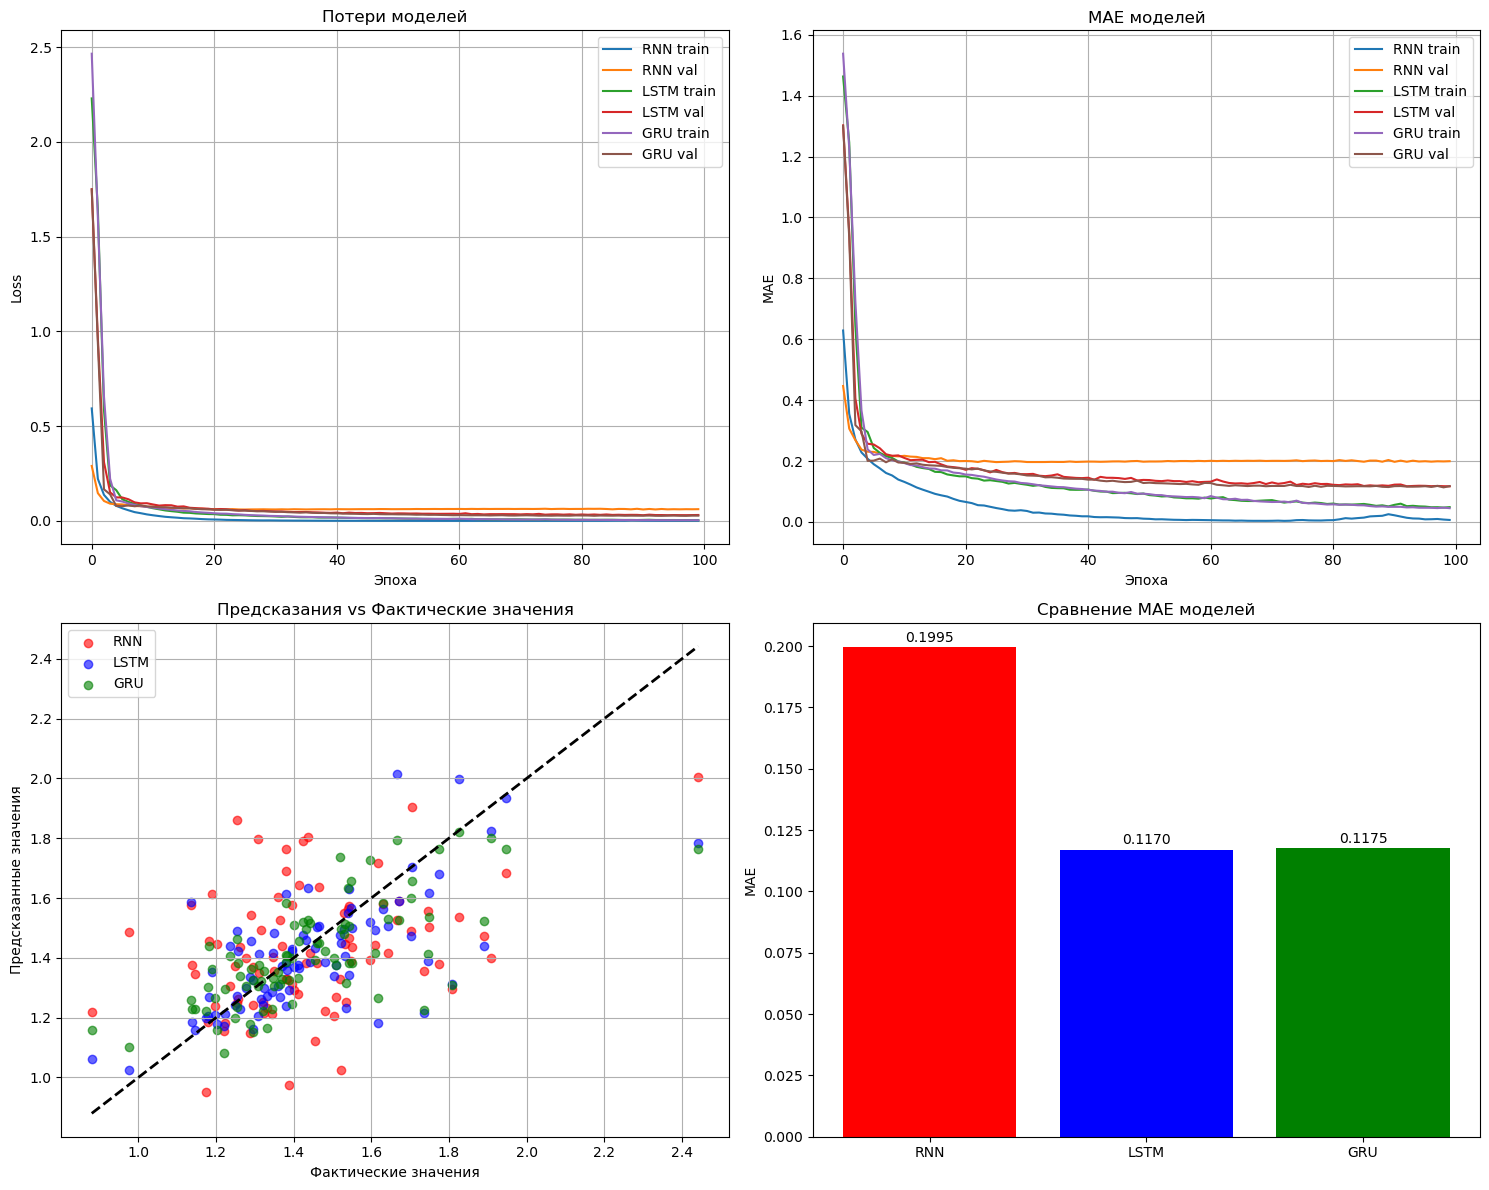

Файл создан: predictions_afr.xlsx


In [333]:
# основной процесс
print("Подготовка данных...")
df_clean = clean_numeric_dataframe(df, feature_columns + ['СКР'])
X, y = prepare_region_data(df_clean, sequence_length=5)

if X is not None:
    print(f"Размерность данных: X {X.shape}, y {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Обучающая выборка: {X_train.shape[0]} примеров")
    print(f"Тестовая выборка: {X_test.shape[0]} примеров")
    
    # обучение моделей
    sequence_length = X_train.shape[1]
    n_features = X_train.shape[2]
    
    models, histories = train_models(X_train, y_train, X_test, y_test, sequence_length, n_features, custom_batch=32, custom_epoch=100)
    
    # оценка моделей
    print("\nРезультаты оценки моделей:")
    results = evaluate_models_with_medians(models, X_test, y_test)
    
    plot_results(histories, models, X_test, y_test)
    


In [337]:
simple_result = create_excel(df_clean, models['GRU'], feature_columns, 'predictions_afr.xlsx', 'СКР')

Файл создан: predictions_afr.xlsx


Подготовка данных...
Обработка столбца: Численность населения
Обработка столбца: Число умерших
Обработка столбца: Общая численность инвалидов
Обработка столбца: Кол-во преступлений
Обработка столбца: Валовой региональный продукт на душу населения (ОКВЭД 2)
Обработка столбца: Величина прожиточного минимума
Обработка столбца: Уровень бедности
Обработка столбца: Средняя ЗП
Обработка столбца: Численность врачей всех специальностей
Обработка столбца: Число больничных организаций на конец отчетного года
Обработка столбца: Число санаторно-курортных организаций
Обработка столбца: Младенческая смертность коэф
Обработка столбца: Браков
Обработка столбца: Разводов
Обработка столбца: ОПЖ
Размерность данных: X (595, 3, 14), y (595,)
Обучающая выборка: 476 примеров
Тестовая выборка: 119 примеров


C:\Users\lego\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Обучение RNN модели...
Обучение LSTM модели...
Обучение GRU модели...

Результаты оценки моделей:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
RNN:
  MAE: 2.9109 | MedAE: 1.9710
  MSE: 18.7727 | MedSE: 3.8850
  RMSE: 2.9109 | MedRSE: 1.9710

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step
LSTM:
  MAE: 1.8337 | MedAE: 1.4192
  MSE: 6.0232 | MedSE: 2.0142
  RMSE: 1.8337 | MedRSE: 1.4192

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
GRU:
  MAE: 1.4647 | MedAE: 1.2022
  MSE: 3.5915 | MedSE: 1.4453
  RMSE: 1.4647 | MedRSE: 1.2022

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RNN модель:
  MAE: 2.9109
  MSE: 18.7727
  RMSE: 4.3328

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM модель:
  MAE: 1.8337
  MSE: 6.0232
  RMSE: 2.4542

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
GRU модель:
  MAE: 1.4647
  MSE: 3.5915
  RMSE: 1.8951



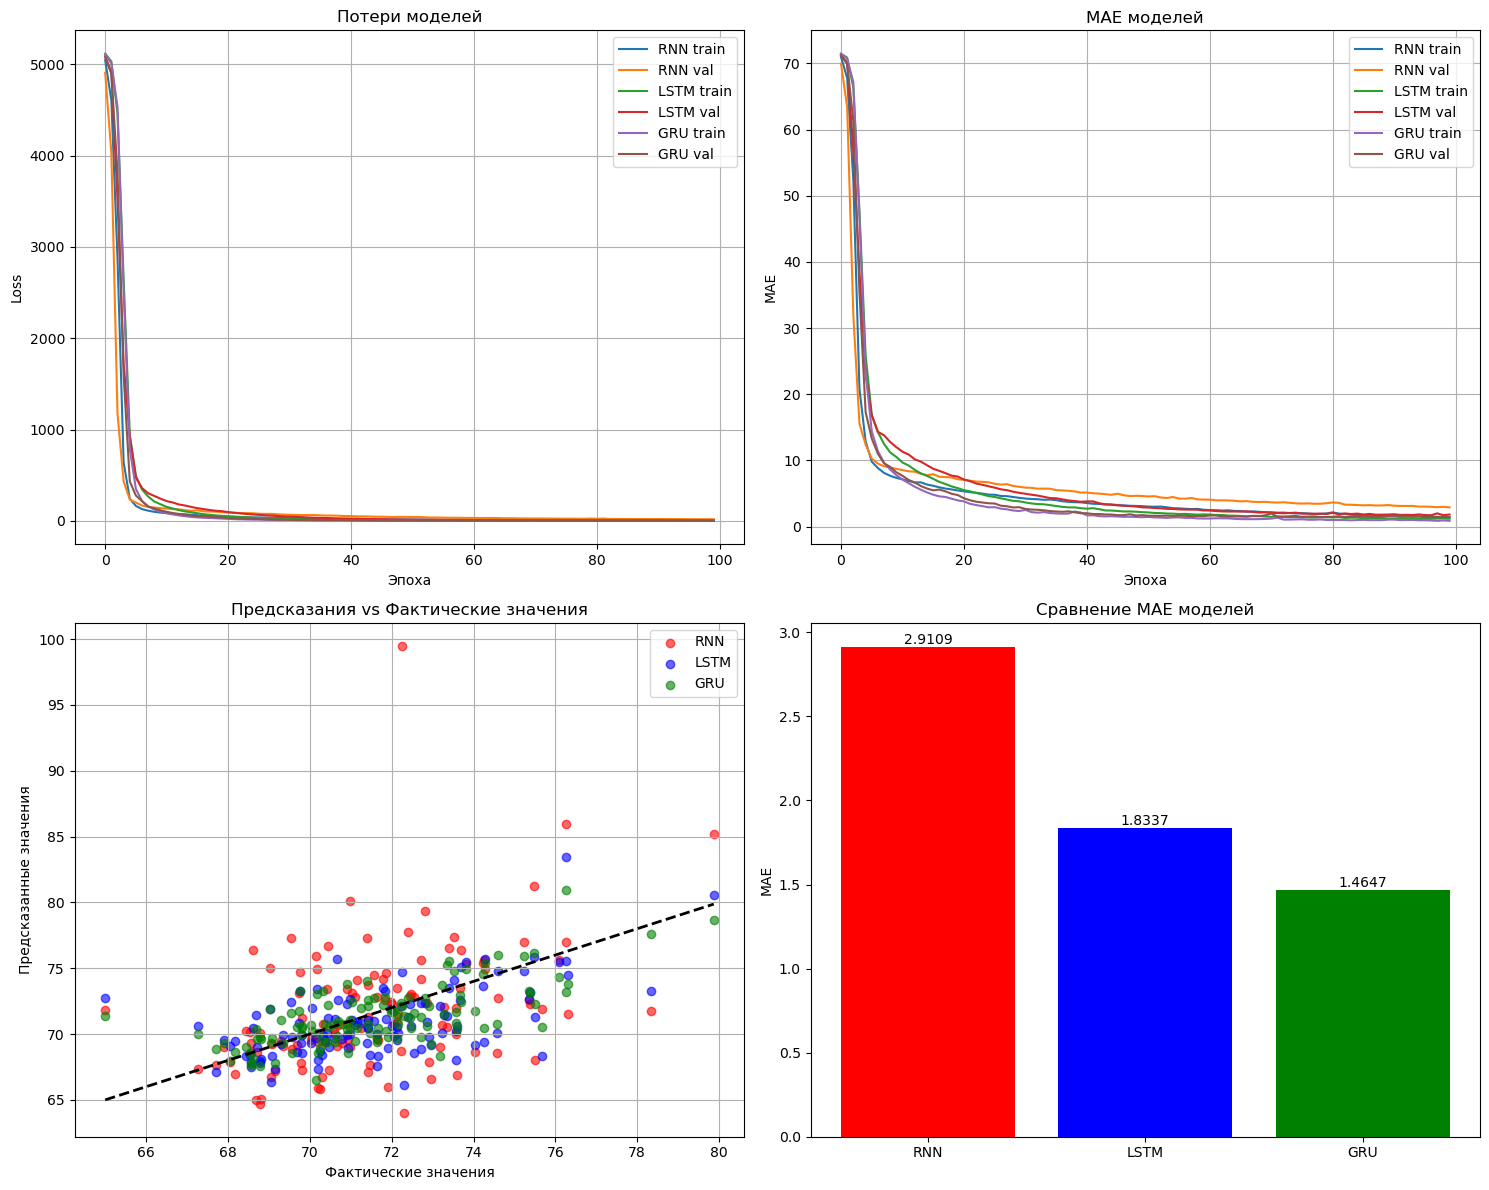

In [339]:
# основной процесс
print("Подготовка данных...")
df_clean_1 = clean_numeric_dataframe(df_1, feature_columns_1 + ['ОПЖ'])
X, y = prepare_region_data_1(df_clean_1, sequence_length=3)

if X is not None:
    print(f"Размерность данных: X {X.shape}, y {y.shape}")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    print(f"Обучающая выборка: {X_train.shape[0]} примеров")
    print(f"Тестовая выборка: {X_test.shape[0]} примеров")
    
    # обучение моделей
    sequence_length = X_train.shape[1]
    n_features = X_train.shape[2]
    
    models, histories = train_models(X_train, y_train, X_test, y_test, sequence_length, n_features, custom_batch=32, custom_epoch=100)
    
    # оценка моделей
    print("\nРезультаты оценки моделей:")
    results = evaluate_models_with_medians(models, X_test, y_test)
    
    plot_results(histories, models, X_test, y_test)



In [341]:
simple_result = create_excel(df_clean_1, models['GRU'], feature_columns_1, 'predictions_ele.xlsx', 'ОПЖ')

Файл создан: predictions_ele.xlsx
